Visualizing Parameter Space Distribution (P, Rho, dt) from Splits
Base directory: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt
Loading metadata from: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/normalized_datasets/normalization_metadata.json
  [Debug] Found 'original_metadata.case_info'. Processing entries...
Successfully built dt_lookup with 500 entries.
Found 400 cases in train split
Found 25 cases in val split
Found 75 cases in test split

PARAMETER SPACE ANALYSIS (P, Rho, dt)

Overall Parameter Space:
  Pressure range: 50000 - 168750 Pa
  Density range:  0.500 - 2.000 kg/m³
  dt range:       3.84e-06 - 1.41e-05 s
  Total cases: 500
  Unique pressures: 20
  Unique densities: 25
  Unique dt:      381

Split Distribution:
  TRAIN: 400 cases
    Pressure: 50000 - 168750 Pa
    Density:  0.500 - 2.000 kg/m³
    dt:       4.25e-06 - 1.33e-05 s
  VAL: 25 cases
    Pressure: 100000 

/tmp/ipykernel_5526/109621132.py:278: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(split_names, fontsize=12)


Concise visualization saved to: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/parameter_space_analysis_concise.png
Concise PDF saved to: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/parameter_space_analysis_concise.pdf


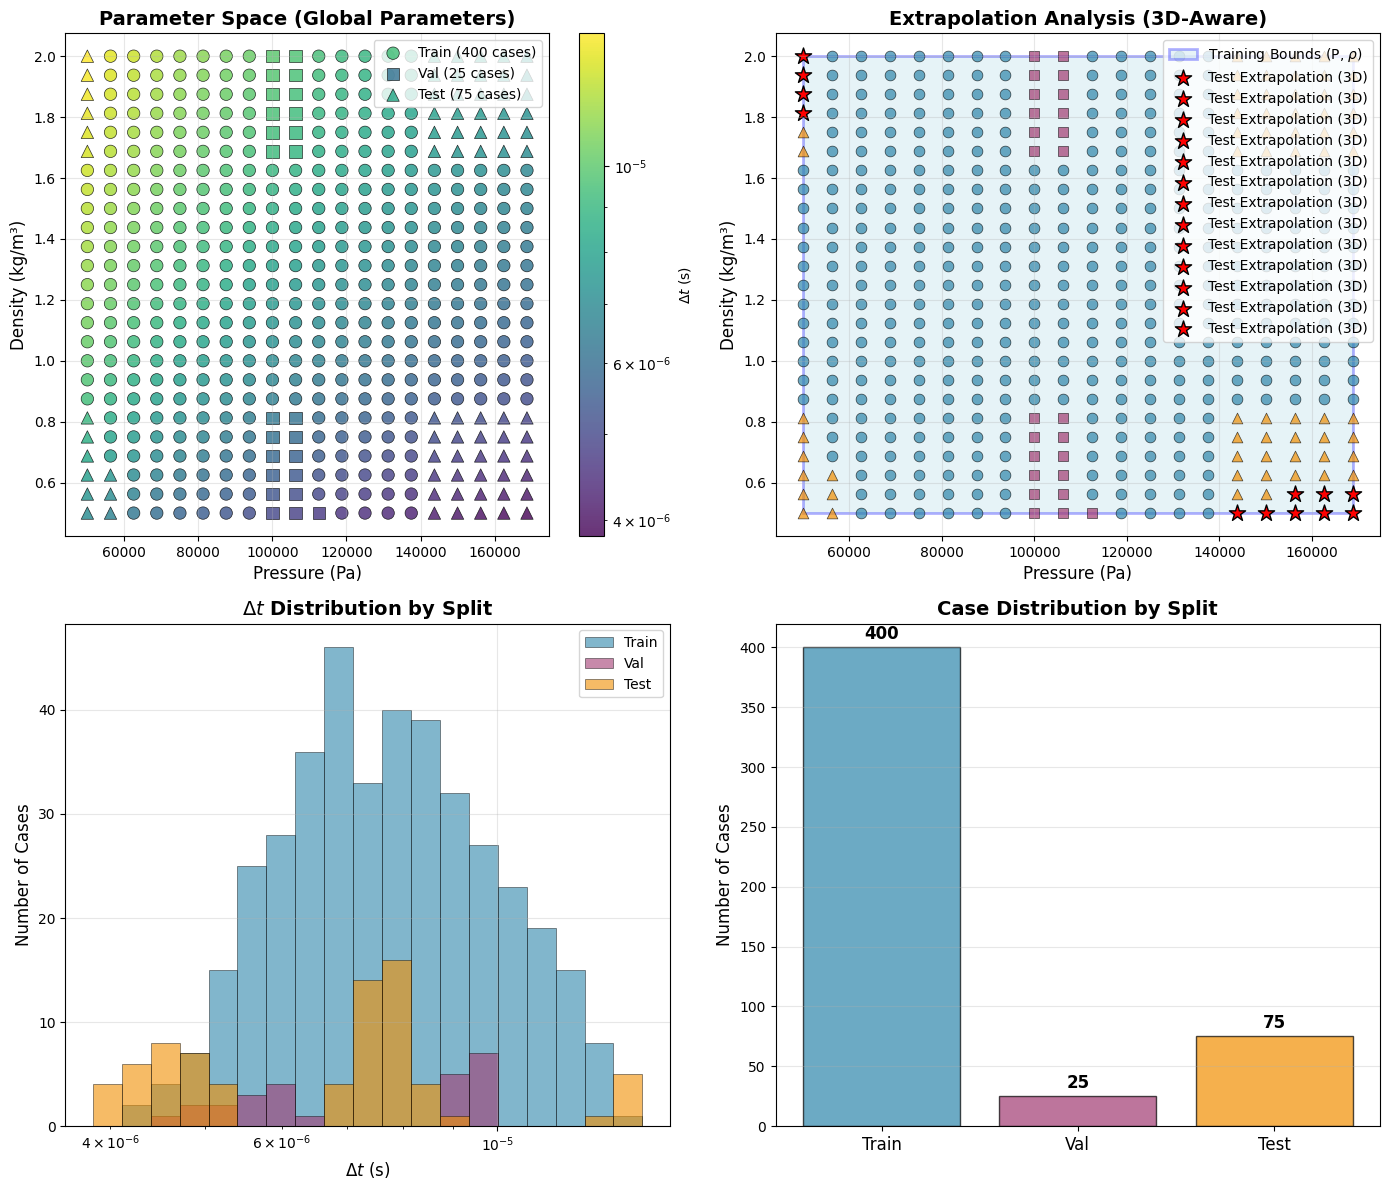


Analysis data saved to: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/parameter_split_analysis.json

Visualization complete!


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from pathlib import Path
import re
from collections import defaultdict
import json

class ParameterSplitVisualizer:
    """
    Visualize parameter space (Pressure, Density, dt) distribution.
    P and Rho are from filenames, dt is from a metadata JSON.
    """
    
    def __init__(self, base_dir, metadata_path):
        self.base_dir = Path(base_dir)
        self.splits = ['train', 'val', 'test']
        self.colors = {'train': '#2E86AB', 'val': '#A23B72', 'test': '#F18F01'}
        self.markers = {'train': 'o', 'val': 's', 'test': '^'}
        
        print(f"Loading metadata from: {metadata_path}")
        # NEW: Load the dt lookup table on initialization
        self.dt_lookup = self._load_dt_lookup(metadata_path)

    def _load_dt_lookup(self, metadata_path):
        """
        Loads the metadata JSON and builds a (pressure, density) -> dt lookup
        by parsing the "original_metadata.case_info" structure.
        """
        lookup = {}
        try:
            with open(metadata_path, 'r') as f:
                data = json.load(f)
            
            # --- START OF NEW, CORRECT LOGIC ---
            
            # Navigate to the correct nested dictionary
            case_info_dict = data.get("original_metadata", {}).get("case_info", {})
            
            if not case_info_dict:
                print(f"Warning: 'original_metadata.case_info' key not found or is empty in JSON.")
                return {}

            print(f"  [Debug] Found 'original_metadata.case_info'. Processing entries...")
            
            count_success = 0
            # Iterate through all case entries in the dictionary
            for case_name, case_data in case_info_dict.items():
                try:
                    # Extract the parameters from their *correct* locations
                    p = float(case_data["parameters"]["pressure_numeric"])
                    d = float(case_data["parameters"]["density_numeric"])
                    dt = float(case_data["delta_t"])
                    
                    # Create the lookup key
                    lookup[(p, d)] = dt
                    count_success += 1
                    
                except (KeyError, TypeError, ValueError) as e:
                    # This will catch any case_data that is malformed
                    print(f"  [Debug] Skipping case '{case_name}': missing data. Error: {e}")
            
            # --- END OF NEW, CORRECT LOGIC ---
            
            if not lookup:
                print(f"Warning: Failed to build dt_lookup. 0 entries found.")
            else:
                print(f"Successfully built dt_lookup with {count_success} entries.")
                
        except json.JSONDecodeError:
            print(f"Error: {metadata_path} is not a valid JSON file.")
            return {}
        except FileNotFoundError:
            print(f"Error: Metadata file not found at {metadata_path}")
            return {}
        except Exception as e:
            print(f"An unexpected error occurred loading {metadata_path}: {e}")
            return {}
            
        return lookup

    def extract_parameters_from_filename(self, filename):
        """Extract pressure and density from case filename."""
        # Pattern: p_L_125000_rho_L_1.5_split_with_pos.pt
        pressure_match = re.search(r'p_L_(\d+)', filename)
        density_match = re.search(r'rho_L_([\d.]+)', filename)
        
        pressure = float(pressure_match.group(1)) if pressure_match else None
        density = float(density_match.group(1)) if density_match else None
        
        return pressure, density
    
    def load_split_parameters(self):
        """Load parameter information from all split directories."""
        split_data = {}
        
        for split in self.splits:
            split_dir = self.base_dir / f"{split}_cases"
            split_data[split] = {'pressures': [], 'densities': [], 'dts': [], 'case_names': []}
            
            if not split_dir.exists():
                print(f"Warning: {split_dir} not found, skipping {split} split")
                continue
            
            case_files = list(split_dir.glob("*.pt"))
            print(f"Found {len(case_files)} cases in {split} split")
            
            debug_file_printed = False 
            
            for case_file in case_files:
                # 1. Get Pressure and Density from filename
                pressure, density = self.extract_parameters_from_filename(case_file.name)
                
                # 2. Get dt from the lookup table using (p, d) as the key
                dt = None
                if pressure is not None and density is not None:
                    dt = self.dt_lookup.get((pressure, density))

                # 3. If all three are found, add them
                if pressure is not None and density is not None and dt is not None:
                    split_data[split]['pressures'].append(pressure)
                    split_data[split]['densities'].append(density)
                    split_data[split]['dts'].append(dt)
                    
                    case_name = case_file.name.replace(f'_{split}_with_pos.pt', '')
                    split_data[split]['case_names'].append(case_name)
                
                # 4. Debug print for the *first* failure
                elif not debug_file_printed:
                    print(f"  [Debug] Failed to get all parameters for: {case_file.name}")
                    print(f"    - From file: Pressure={pressure}, Density={density}")
                    print(f"    - From lookup: dt={dt}")
                    if dt is None and (pressure and density):
                         print(f"    - ^ No dt found in metadata for key: ({pressure}, {density})")
                    debug_file_printed = True
        
        return split_data
    
    def analyze_parameter_space(self, split_data):
        """Analyze the parameter space coverage."""
        all_pressures = []
        all_densities = []
        all_dts = []
        
        for split in self.splits:
            all_pressures.extend(split_data[split]['pressures'])
            all_densities.extend(split_data[split]['densities'])
            all_dts.extend(split_data[split]['dts'])
            
        analysis = {
            'pressure_range': [min(all_pressures), max(all_pressures)] if all_pressures else [0, 0],
            'density_range': [min(all_densities), max(all_densities)] if all_densities else [0, 0],
            'dt_range': [min(all_dts), max(all_dts)] if all_dts else [0, 0],
            'unique_pressures': sorted(set(all_pressures)),
            'unique_densities': sorted(set(all_densities)),
            'unique_dts': sorted(set(all_dts)),
            'total_cases': len(all_pressures)
        }
        
        return analysis
    
    def create_visualizations(self, split_data, output_dir=None):
        """Create concise 2x2 parameter space visualizations."""
        if output_dir is None:
            output_dir = self.base_dir
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        ax1, ax2, ax3, ax4 = axes.flatten()

        all_pressures = []
        all_densities = []
        all_dts = []
        for split in self.splits:
            all_pressures.extend(split_data[split]['pressures'])
            all_densities.extend(split_data[split]['densities'])
            all_dts.extend(split_data[split]['dts'])
            
        if not all_dts:
            print("Plotting Error: No data was successfully loaded to plot.")
            plt.close(fig)
            return

        dt_min, dt_max = min(all_dts), max(all_dts)
        
        # --- 1. Parameter space scatter plot (P vs. Rho, colored by dt) ---
        for split in self.splits:
            data = split_data[split]
            if data['pressures'] and data['densities']:
                sc = ax1.scatter(data['pressures'], data['densities'],  
                                 c=data['dts'], 
                                 norm=LogNorm(vmin=dt_min, vmax=dt_max),
                                 cmap='viridis',
                                 marker=self.markers[split],  
                                 alpha=0.8, s=80, 
                                 label=f'{split.title()} ({len(data["pressures"])} cases)',
                                 edgecolors='black', linewidth=0.5)
        
        fig.colorbar(sc, ax=ax1, label=r'$\Delta t$ (s)')
        ax1.set_xlabel('Pressure (Pa)', fontsize=12)
        ax1.set_ylabel('Density (kg/m³)', fontsize=12)
        ax1.set_title('Parameter Space (Global Parameters)', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # --- 2. Extrapolation analysis (3D aware) ---
        train_data = split_data['train']
        if train_data['pressures'] and train_data['densities'] and train_data['dts']:
            train_p_min, train_p_max = min(train_data['pressures']), max(train_data['pressures'])
            train_d_min, train_d_max = min(train_data['densities']), max(train_data['densities'])
            train_dt_min, train_dt_max = min(train_data['dts']), max(train_data['dts'])
            
            rect = Rectangle((train_p_min, train_d_min),  
                             train_p_max - train_p_min,  
                             train_d_max - train_d_min,
                             linewidth=2, edgecolor='blue',  
                             facecolor='lightblue', alpha=0.3,
                             label=r'Training Bounds (P, $\rho$)')
            ax2.add_patch(rect)
            
            extrapolation_handles = []
            for split in self.splits:
                data = split_data[split]
                for p, d, dt in zip(data['pressures'], data['densities'], data['dts']):
                    is_extrapolation = (p < train_p_min or p > train_p_max or  
                                        d < train_d_min or d > train_d_max or
                                        dt < train_dt_min or dt > train_dt_max)
                    
                    if split == 'test' and is_extrapolation:
                        h = ax2.scatter(p, d, c='red', marker='*', s=150,  
                                    edgecolors='black', linewidth=1,
                                    label='Test Extrapolation (3D)')
                        if not any(h.get_label() == handle.get_label() for handle in extrapolation_handles):
                            extrapolation_handles.append(h)
                    else:
                        ax2.scatter(p, d, c=self.colors[split],  
                                    marker=self.markers[split], alpha=0.7, s=60,
                                    edgecolors='black', linewidth=0.5)
            
            handles, labels = ax2.get_legend_handles_labels()
            unique_labels = {r'Training Bounds (P, $\rho$)', 'Test Extrapolation (3D)'}
            final_handles = [h for h, l in zip(handles, labels) if l in unique_labels] + extrapolation_handles
            ax2.legend(handles=final_handles, fontsize=10)

        ax2.set_xlabel('Pressure (Pa)', fontsize=12)
        ax2.set_ylabel('Density (kg/m³)', fontsize=12)
        ax2.set_title('Extrapolation Analysis (3D-Aware)', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # --- 3. dt distribution histogram ---
        if all_dts:
            bins = np.logspace(np.log10(dt_min), np.log10(dt_max), 20)
            for split in self.splits:
                data = split_data[split]
                if data['dts']:
                    ax3.hist(data['dts'], bins=bins, alpha=0.6,  
                             color=self.colors[split], label=f'{split.title()}',
                             edgecolor='black', linewidth=0.5)
            ax3.set_xscale('log')
        
        ax3.set_xlabel(r'$\Delta t$ (s)', fontsize=12)
        ax3.set_ylabel('Number of Cases', fontsize=12)
        ax3.set_title(r'$\Delta t$ Distribution by Split', fontsize=14, fontweight='bold')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        # --- 4. Case count comparison ---
        split_names = [split.title() for split in self.splits if split_data[split]['pressures']]
        case_counts = [len(split_data[split]['pressures']) for split in self.splits if split_data[split]['pressures']]
        
        if case_counts:
            bars = ax4.bar(split_names, case_counts,  
                           color=[self.colors[split] for split in self.splits if split_data[split]['pressures']],
                           alpha=0.7, edgecolor='black', linewidth=1)
            
            ax4.bar_label(bars, fmt='%d', fontsize=12, fontweight='bold', padding=3)
            ax4.set_xticklabels(split_names, fontsize=12)
        
        ax4.set_ylabel('Number of Cases', fontsize=12)
        ax4.set_title('Case Distribution by Split', fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        
        output_path = Path(output_dir)
        viz_file = output_path / 'parameter_space_analysis_concise.png'
        plt.savefig(viz_file, dpi=300, bbox_inches='tight')
        print(f"Concise visualization saved to: {viz_file}")
        
        viz_file_pdf = output_path / 'parameter_space_analysis_concise.pdf'
        plt.savefig(viz_file_pdf, bbox_inches='tight')
        print(f"Concise PDF saved to: {viz_file_pdf}")
        
        plt.show()
        
        return fig

    def print_parameter_analysis(self, split_data, analysis):
        """Print detailed parameter analysis to console."""
        print("\n" + "="*80)
        print("PARAMETER SPACE ANALYSIS (P, Rho, dt)")
        print("="*80)
        
        if analysis['total_cases'] > 0:
            print(f"\nOverall Parameter Space:")
            print(f"  Pressure range: {analysis['pressure_range'][0]:.0f} - {analysis['pressure_range'][1]:.0f} Pa")
            print(f"  Density range:  {analysis['density_range'][0]:.3f} - {analysis['density_range'][1]:.3f} kg/m³")
            print(f"  dt range:       {analysis['dt_range'][0]:.2e} - {analysis['dt_range'][1]:.2e} s")
            print(f"  Total cases: {analysis['total_cases']}")
            print(f"  Unique pressures: {len(analysis['unique_pressures'])}")
            print(f"  Unique densities: {len(analysis['unique_densities'])}")
            print(f"  Unique dt:      {len(analysis['unique_dts'])}")
        else:
            print("\nOverall Parameter Space: No data loaded.")

        print(f"\nSplit Distribution:")
        for split in self.splits:
            data = split_data[split]
            if data['pressures']:
                p_range = f"{min(data['pressures']):.0f} - {max(data['pressures']):.0f}"
                d_range = f"{min(data['densities']):.3f} - {max(data['densities']):.3f}"
                dt_range = f"{min(data['dts']):.2e} - {max(data['dts']):.2e}"
                print(f"  {split.upper()}: {len(data['pressures'])} cases")
                print(f"    Pressure: {p_range} Pa")
                print(f"    Density:  {d_range} kg/m³")
                print(f"    dt:       {dt_range} s")
            else:
                print(f"  {split.upper()}: No cases found")
        
        # Extrapolation analysis
        train_data = split_data['train']
        test_data = split_data['test']
        
        if train_data['pressures'] and test_data['pressures']:
            train_p_min, train_p_max = min(train_data['pressures']), max(train_data['pressures'])
            train_d_min, train_d_max = min(train_data['densities']), max(train_data['densities'])
            train_dt_min, train_dt_max = min(train_data['dts']), max(train_data['dts'])
            
            test_extrapolation_cases = 0
            for p, d, dt in zip(test_data['pressures'], test_data['densities'], test_data['dts']):
                if (p < train_p_min or p > train_p_max or 
                    d < train_d_min or d > train_d_max or
                    dt < train_dt_min or dt > train_dt_max):
                    test_extrapolation_cases += 1
            
            print(f"\nExtrapolation Analysis (3D):")
            print(f"  Training bounds:")
            print(f"    Pressure: [{train_p_min:.0f}, {train_p_max:.0f}] Pa")
            print(f"    Density:  [{train_d_min:.3f}, {train_d_max:.3f}] kg/m³")
            print(f"    dt:       [{train_dt_min:.2e}, {train_dt_max:.2e}] s")
            
            if len(test_data['pressures']) > 0:
                percent_extrap = test_extrapolation_cases / len(test_data['pressures']) * 100
                print(f"  Test extrapolation cases: {test_extrapolation_cases}/{len(test_data['pressures'])} ({percent_extrap:.1f}%)")
            else:
                print("  Test extrapolation cases: 0/0")
        elif train_data['pressures']:
            print("\nExtrapolation Analysis (3D): No test data to compare.")
        else:
            print("\nExtrapolation Analysis (3D): No training data to set bounds.")


    def save_analysis_json(self, split_data, analysis, output_dir=None):
        if output_dir is None:
            output_dir = self.base_dir
        
        output_data = {
            'parameter_analysis': analysis,
            'split_data': split_data,
            'timestamp': str(np.datetime64('now'))
        }
        
        json_file = Path(output_dir) / 'parameter_split_analysis.json'
        with open(json_file, 'w') as f:
            json.dump(output_data, f, indent=2)
        
        print(f"\nAnalysis data saved to: {json_file}")


def main():
    """Main execution function."""
    
    # --- PLEASE CHECK THESE PATHS ---
    BASE_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt"
    
    # Path to your metadata file
    METADATA_PATH = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/normalized_datasets/normalization_metadata.json"
    # ---
    
    
    print("Visualizing Parameter Space Distribution (P, Rho, dt) from Splits")
    print("="*80)
    print(f"Base directory: {BASE_DIR}")
    
    visualizer = ParameterSplitVisualizer(BASE_DIR, METADATA_PATH)
    
    if not visualizer.dt_lookup:
        print("\nHalting execution: dt_lookup dictionary is empty.")
        print("Please check the JSON path and the '_load_dt_lookup' method.")
        return

    split_data = visualizer.load_split_parameters()
    
    if not split_data['train']['pressures'] and not split_data['val']['pressures'] and not split_data['test']['pressures']:
        print("\nNo data was loaded from any split.")
        print("Please check 'BASE_DIR' and filename patterns.")
    else:
        analysis = visualizer.analyze_parameter_space(split_data)
        visualizer.print_parameter_analysis(split_data, analysis)
        visualizer.create_visualizations(split_data)
        visualizer.save_analysis_json(split_data, analysis)
        print("\nVisualization complete!")


if __name__ == "__main__":
    main()

# Working

Visualizing Parameter Space Distribution from Train/Test/Val Splits
Base directory: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt
Found 400 cases in train split
Found 25 cases in val split
Found 75 cases in test split

PARAMETER SPACE ANALYSIS

Overall Parameter Space:
  Pressure range: 50000 - 168750 Pa
  Density range:  0.500 - 2.000 kg/m³
  Total cases: 500
  Unique pressures: 20
  Unique densities: 25

Split Distribution:
  TRAIN: 400 cases
    Pressure: 50000 - 168750 Pa
    Density:  0.500 - 2.000 kg/m³
  VAL: 25 cases
    Pressure: 100000 - 112500 Pa
    Density:  0.500 - 2.000 kg/m³
  TEST: 75 cases
    Pressure: 50000 - 168750 Pa
    Density:  0.500 - 2.000 kg/m³

Extrapolation Analysis:
  Training bounds:
    Pressure: [50000, 168750] Pa
    Density:  [0.500, 2.000] kg/m³
  Test extrapolation cases: 0/75 (0.0%)
Visualization saved to: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/diff

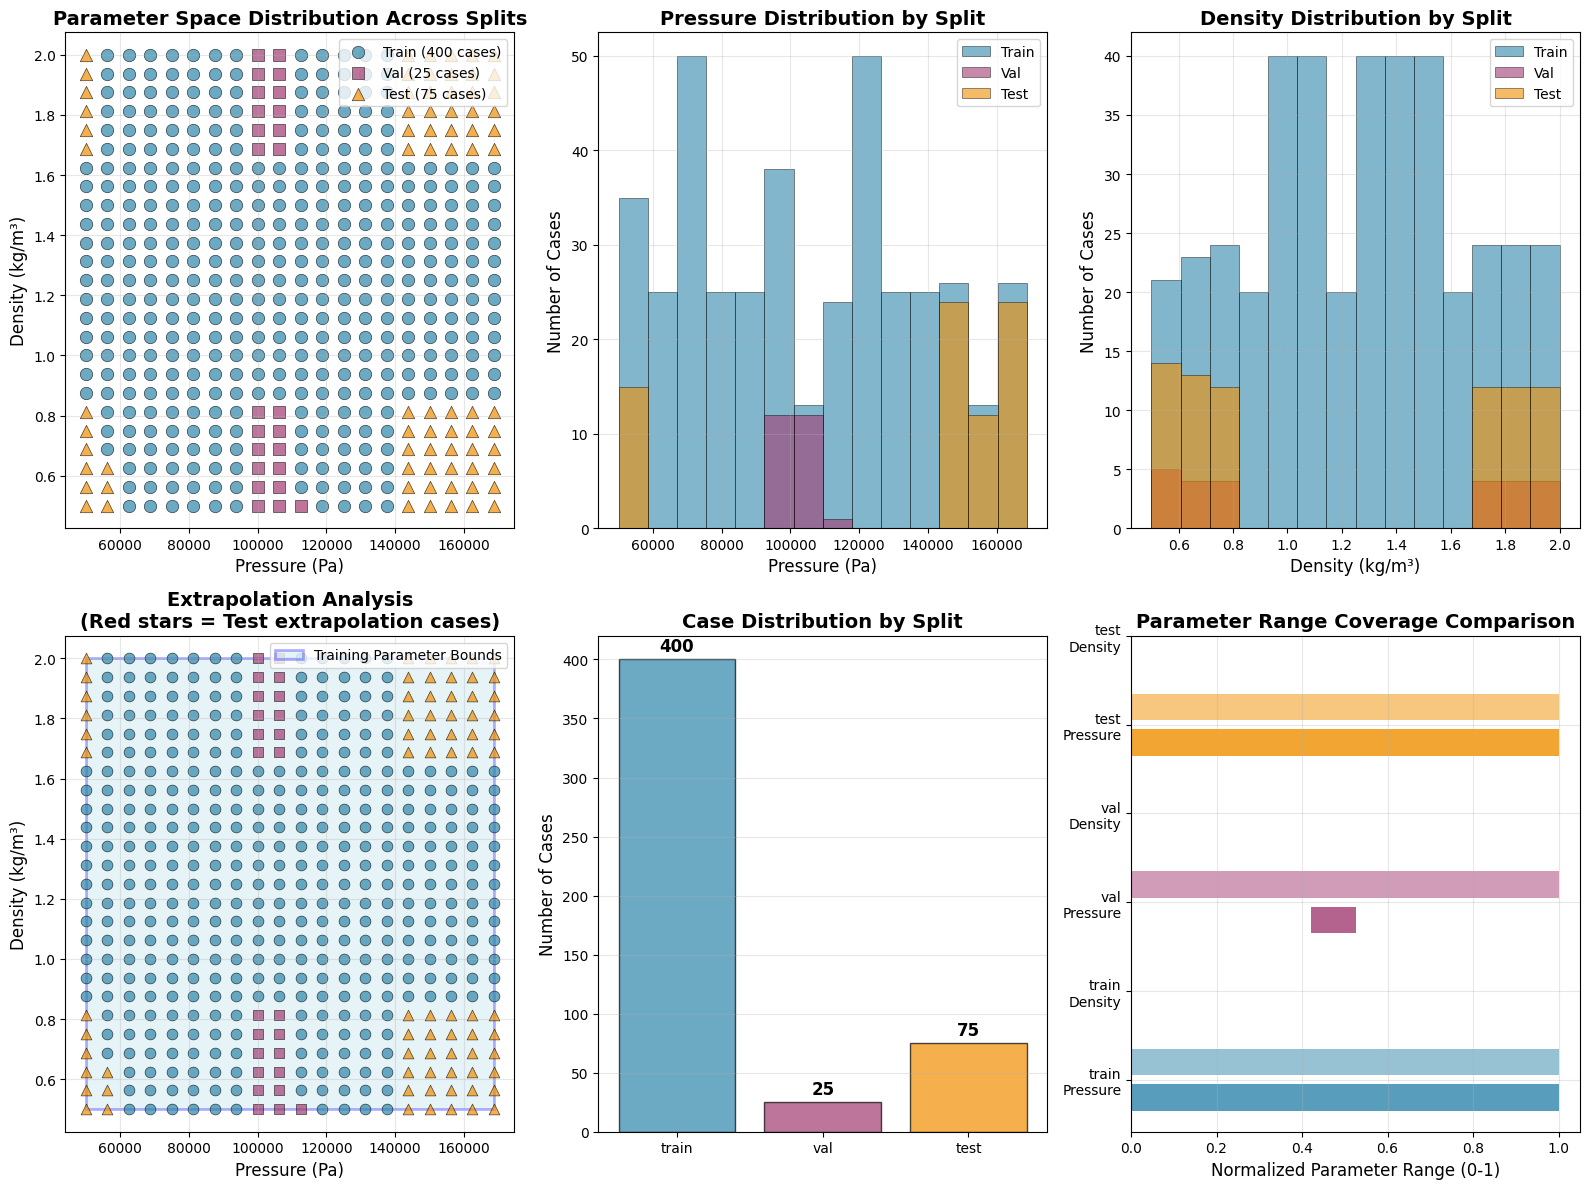

Analysis data saved to: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/parameter_split_analysis.json

Visualization complete!


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from collections import defaultdict
import json

class ParameterSplitVisualizer:
    """
    Visualize parameter space distribution from existing train/test/val case directories.
    """
    
    def __init__(self, base_dir):
        self.base_dir = Path(base_dir)
        self.splits = ['train', 'val', 'test']
        self.colors = {'train': '#2E86AB', 'val': '#A23B72', 'test': '#F18F01'}
        self.markers = {'train': 'o', 'val': 's', 'test': '^'}
        
    def extract_parameters_from_filename(self, filename):
        """Extract pressure and density from case filename."""
        # Pattern: p_L_125000_rho_L_1.5_split_with_pos.pt
        pressure_match = re.search(r'p_L_(\d+)', filename)
        density_match = re.search(r'rho_L_([\d.]+)', filename)
        
        pressure = float(pressure_match.group(1)) if pressure_match else None
        density = float(density_match.group(1)) if density_match else None
        
        return pressure, density
    
    def load_split_parameters(self):
        """Load parameter information from all split directories."""
        split_data = {}
        
        for split in self.splits:
            split_dir = self.base_dir / f"{split}_cases"
            split_data[split] = {'pressures': [], 'densities': [], 'case_names': []}
            
            if not split_dir.exists():
                print(f"Warning: {split_dir} not found, skipping {split} split")
                continue
            
            # Get all .pt files in the split directory
            case_files = list(split_dir.glob("*.pt"))
            print(f"Found {len(case_files)} cases in {split} split")
            
            for case_file in case_files:
                pressure, density = self.extract_parameters_from_filename(case_file.name)
                if pressure is not None and density is not None:
                    split_data[split]['pressures'].append(pressure)
                    split_data[split]['densities'].append(density)
                    # Extract case name (remove split suffix)
                    case_name = case_file.name.replace(f'_{split}_with_pos.pt', '')
                    split_data[split]['case_names'].append(case_name)
        
        return split_data
    
    def analyze_parameter_space(self, split_data):
        """Analyze the parameter space coverage."""
        all_pressures = []
        all_densities = []
        
        for split in self.splits:
            all_pressures.extend(split_data[split]['pressures'])
            all_densities.extend(split_data[split]['densities'])
        
        analysis = {
            'pressure_range': [min(all_pressures), max(all_pressures)] if all_pressures else [0, 0],
            'density_range': [min(all_densities), max(all_densities)] if all_densities else [0, 0],
            'unique_pressures': sorted(set(all_pressures)),
            'unique_densities': sorted(set(all_densities)),
            'total_cases': len(all_pressures)
        }
        
        return analysis
    
    def create_visualizations(self, split_data, output_dir=None):
        """Create comprehensive parameter space visualizations."""
        if output_dir is None:
            output_dir = self.base_dir
        
        fig = plt.figure(figsize=(16, 12))
        
        # 1. Parameter space scatter plot
        ax1 = plt.subplot(2, 3, 1)
        for split in self.splits:
            data = split_data[split]
            if data['pressures'] and data['densities']:
                ax1.scatter(data['pressures'], data['densities'], 
                           c=self.colors[split], marker=self.markers[split], 
                           alpha=0.7, s=80, label=f'{split.title()} ({len(data["pressures"])} cases)',
                           edgecolors='black', linewidth=0.5)
        
        ax1.set_xlabel('Pressure (Pa)', fontsize=12)
        ax1.set_ylabel('Density (kg/m³)', fontsize=12)
        ax1.set_title('Parameter Space Distribution Across Splits', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # 2. Pressure distribution histogram
        ax2 = plt.subplot(2, 3, 2)
        all_pressures = []
        for split in self.splits:
            all_pressures.extend(split_data[split]['pressures'])
        
        if all_pressures:
            pressure_bins = np.linspace(min(all_pressures), max(all_pressures), 15)
            for split in self.splits:
                data = split_data[split]
                if data['pressures']:
                    ax2.hist(data['pressures'], bins=pressure_bins, alpha=0.6, 
                            color=self.colors[split], label=f'{split.title()}',
                            edgecolor='black', linewidth=0.5)
        
        ax2.set_xlabel('Pressure (Pa)', fontsize=12)
        ax2.set_ylabel('Number of Cases', fontsize=12)
        ax2.set_title('Pressure Distribution by Split', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # 3. Density distribution histogram
        ax3 = plt.subplot(2, 3, 3)
        all_densities = []
        for split in self.splits:
            all_densities.extend(split_data[split]['densities'])
        
        if all_densities:
            density_bins = np.linspace(min(all_densities), max(all_densities), 15)
            for split in self.splits:
                data = split_data[split]
                if data['densities']:
                    ax3.hist(data['densities'], bins=density_bins, alpha=0.6, 
                            color=self.colors[split], label=f'{split.title()}',
                            edgecolor='black', linewidth=0.5)
        
        ax3.set_xlabel('Density (kg/m³)', fontsize=12)
        ax3.set_ylabel('Number of Cases', fontsize=12)
        ax3.set_title('Density Distribution by Split', fontsize=14, fontweight='bold')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        # 4. Training bounds analysis
        ax4 = plt.subplot(2, 3, 4)
        
        # Get training bounds
        train_data = split_data['train']
        if train_data['pressures'] and train_data['densities']:
            train_p_min, train_p_max = min(train_data['pressures']), max(train_data['pressures'])
            train_d_min, train_d_max = min(train_data['densities']), max(train_data['densities'])
            
            # Draw training bounds rectangle
            from matplotlib.patches import Rectangle
            rect = Rectangle((train_p_min, train_d_min), 
                           train_p_max - train_p_min, 
                           train_d_max - train_d_min,
                           linewidth=2, edgecolor='blue', 
                           facecolor='lightblue', alpha=0.3,
                           label='Training Parameter Bounds')
            ax4.add_patch(rect)
            
            # Plot all points with extrapolation highlighting
            for split in self.splits:
                data = split_data[split]
                for p, d in zip(data['pressures'], data['densities']):
                    is_extrapolation = (p < train_p_min or p > train_p_max or 
                                      d < train_d_min or d > train_d_max)
                    
                    if split == 'test' and is_extrapolation:
                        # Highlight test extrapolation cases
                        ax4.scatter(p, d, c='red', marker='*', s=150, 
                                  edgecolors='black', linewidth=1, 
                                  label='Test Extrapolation' if p == data['pressures'][0] else "")
                    else:
                        ax4.scatter(p, d, c=self.colors[split], 
                                  marker=self.markers[split], alpha=0.7, s=60,
                                  edgecolors='black', linewidth=0.5)
        
        ax4.set_xlabel('Pressure (Pa)', fontsize=12)
        ax4.set_ylabel('Density (kg/m³)', fontsize=12)
        ax4.set_title('Extrapolation Analysis\n(Red stars = Test extrapolation cases)', fontsize=14, fontweight='bold')
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        
        # 5. Case count comparison
        ax5 = plt.subplot(2, 3, 5)
        
        split_names = [split for split in self.splits if split_data[split]['pressures']]
        case_counts = [len(split_data[split]['pressures']) for split in split_names]
        
        bars = ax5.bar(split_names, case_counts, 
                      color=[self.colors[split] for split in split_names],
                      alpha=0.7, edgecolor='black', linewidth=1)
        
        # Add value labels on bars
        for bar, count in zip(bars, case_counts):
            ax5.annotate(f'{count}',
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        ax5.set_ylabel('Number of Cases', fontsize=12)
        ax5.set_title('Case Distribution by Split', fontsize=14, fontweight='bold')
        ax5.grid(True, alpha=0.3, axis='y')
        
        # 6. Parameter range coverage
        ax6 = plt.subplot(2, 3, 6)
        
        # Create range comparison
        y_positions = np.arange(len(self.splits))
        
        for i, split in enumerate(self.splits):
            data = split_data[split]
            if data['pressures'] and data['densities']:
                p_min, p_max = min(data['pressures']), max(data['pressures'])
                d_min, d_max = min(data['densities']), max(data['densities'])
                
                # Normalize to 0-1 for visualization
                all_p = []
                all_d = []
                for s in self.splits:
                    all_p.extend(split_data[s]['pressures'])
                    all_d.extend(split_data[s]['densities'])
                
                if all_p and all_d:
                    global_p_min, global_p_max = min(all_p), max(all_p)
                    global_d_min, global_d_max = min(all_d), max(all_d)
                    
                    p_norm_min = (p_min - global_p_min) / (global_p_max - global_p_min) if global_p_max > global_p_min else 0
                    p_norm_max = (p_max - global_p_min) / (global_p_max - global_p_min) if global_p_max > global_p_min else 0
                    
                    ax6.barh(i*2, p_norm_max - p_norm_min, left=p_norm_min, height=0.3,
                            color=self.colors[split], alpha=0.8, 
                            label=f'{split} Pressure' if i == 0 else "")
                    
                    d_norm_min = (d_min - global_d_min) / (global_d_max - global_d_min) if global_d_max > global_d_min else 0
                    d_norm_max = (d_max - global_d_min) / (global_d_max - global_d_min) if global_d_max > global_d_min else 0
                    
                    ax6.barh(i*2+0.4, d_norm_max - d_norm_min, left=d_norm_min, height=0.3,
                            color=self.colors[split], alpha=0.5,
                            label=f'{split} Density' if i == 0 else "")
        
        ax6.set_yticks(np.arange(len(self.splits)*2) + 0.2)
        ax6.set_yticklabels([f'{split}\nPressure' if i%2==0 else f'{split}\nDensity' 
                            for split in self.splits for i in range(2)])
        ax6.set_xlabel('Normalized Parameter Range (0-1)', fontsize=12)
        ax6.set_title('Parameter Range Coverage Comparison', fontsize=14, fontweight='bold')
        ax6.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save the visualization
        output_path = Path(output_dir)
        viz_file = output_path / 'parameter_space_analysis.png'
        plt.savefig(viz_file, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to: {viz_file}")
        
        # Also save as PDF
        viz_file_pdf = output_path / 'parameter_space_analysis.pdf'
        plt.savefig(viz_file_pdf, bbox_inches='tight')
        print(f"PDF saved to: {viz_file_pdf}")
        
        plt.show()
        
        return fig
    
    def print_parameter_analysis(self, split_data, analysis):
        """Print detailed parameter analysis to console."""
        print("\n" + "="*80)
        print("PARAMETER SPACE ANALYSIS")
        print("="*80)
        
        print(f"\nOverall Parameter Space:")
        print(f"  Pressure range: {analysis['pressure_range'][0]:.0f} - {analysis['pressure_range'][1]:.0f} Pa")
        print(f"  Density range:  {analysis['density_range'][0]:.3f} - {analysis['density_range'][1]:.3f} kg/m³")
        print(f"  Total cases: {analysis['total_cases']}")
        print(f"  Unique pressures: {len(analysis['unique_pressures'])}")
        print(f"  Unique densities: {len(analysis['unique_densities'])}")
        
        print(f"\nSplit Distribution:")
        for split in self.splits:
            data = split_data[split]
            if data['pressures']:
                p_range = f"{min(data['pressures']):.0f} - {max(data['pressures']):.0f}"
                d_range = f"{min(data['densities']):.3f} - {max(data['densities']):.3f}"
                print(f"  {split.upper()}: {len(data['pressures'])} cases")
                print(f"    Pressure: {p_range} Pa")
                print(f"    Density:  {d_range} kg/m³")
            else:
                print(f"  {split.upper()}: No cases found")
        
        # Extrapolation analysis
        train_data = split_data['train']
        test_data = split_data['test']
        
        if train_data['pressures'] and test_data['pressures']:
            train_p_min, train_p_max = min(train_data['pressures']), max(train_data['pressures'])
            train_d_min, train_d_max = min(train_data['densities']), max(train_data['densities'])
            
            test_extrapolation_cases = 0
            for p, d in zip(test_data['pressures'], test_data['densities']):
                if p < train_p_min or p > train_p_max or d < train_d_min or d > train_d_max:
                    test_extrapolation_cases += 1
            
            print(f"\nExtrapolation Analysis:")
            print(f"  Training bounds:")
            print(f"    Pressure: [{train_p_min:.0f}, {train_p_max:.0f}] Pa")
            print(f"    Density:  [{train_d_min:.3f}, {train_d_max:.3f}] kg/m³")
            print(f"  Test extrapolation cases: {test_extrapolation_cases}/{len(test_data['pressures'])} ({test_extrapolation_cases/len(test_data['pressures'])*100:.1f}%)")
    
    def save_analysis_json(self, split_data, analysis, output_dir=None):
        """Save analysis results as JSON."""
        if output_dir is None:
            output_dir = self.base_dir
        
        output_data = {
            'parameter_analysis': analysis,
            'split_data': split_data,
            'timestamp': str(np.datetime64('now'))
        }
        
        json_file = Path(output_dir) / 'parameter_split_analysis.json'
        with open(json_file, 'w') as f:
            json.dump(output_data, f, indent=2)
        
        print(f"Analysis data saved to: {json_file}")


def main():
    """Main execution function."""
    BASE_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt"
    
    print("Visualizing Parameter Space Distribution from Train/Test/Val Splits")
    print("="*80)
    print(f"Base directory: {BASE_DIR}")
    
    # Initialize visualizer
    visualizer = ParameterSplitVisualizer(BASE_DIR)
    
    # Load parameter data from split directories
    split_data = visualizer.load_split_parameters()
    
    # Analyze parameter space
    analysis = visualizer.analyze_parameter_space(split_data)
    
    # Print analysis
    visualizer.print_parameter_analysis(split_data, analysis)
    
    # Create visualizations
    visualizer.create_visualizations(split_data)
    
    # Save analysis as JSON
    visualizer.save_analysis_json(split_data, analysis)
    
    print("\nVisualization complete!")


if __name__ == "__main__":
    main()